## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, zscore

from sherlock_helpers.constants import DATA_DIR, EDGECOLOR, FIG_DIR, HAND_REC
from sherlock_helpers.functions import corr_mean, pearsonr_ci, show_source, r2z

import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Helper functions and variables used across multiple notebooks can be found in `/mnt/code/sherlock_helpers/sherlock_helpers`, or on GitHub, [here](https://github.com/ContextLab/sherlock-topic-model-paper/tree/master/code/sherlock_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from sherlock_helpers.functions import show_source<br />    show_source(foo)</pre>

## Define/inspect some functions

In [2]:
show_source(r2z)

In [3]:
show_source(corr_mean)

In [4]:
show_source(pearsonr_ci)

In [5]:
def corr_pearsonr(r_vals, metric2):
    return pearsonr(r2z(np.array(r_vals)), metric2)

In [6]:
def fmt_stat(stat):
    r, p = stat
    if p < .001:
        return f"$r = {r:.2f}$\n$p < .001$"
    else:
        return f"$r = {r:.2f}$\n$p = {round(p, 3)}$"

In [7]:
def precision_func(video, recall):
    return corr_mean(np.max(1 - cdist(video, recall, 'correlation'), 0))

In [8]:
def distinctiveness_func(video, recall):
    corrmat = 1 - cdist(video, recall, 'correlation')
    z_corrs = zscore(corrmat, axis=0)
    return z_corrs.max(axis=0).mean()

## Set plotting params

In [9]:
sns.set_context('paper')
mpl.rcParams['pdf.fonttype'] = 42
cmap = plt.cm.bone_r

## Load data

In [10]:
video_events = np.load(DATA_DIR.joinpath('video_events.npy'), allow_pickle=True)
recall_events = np.load(DATA_DIR.joinpath('recall_events.npy'), allow_pickle=True)
event_mappings = np.load(DATA_DIR.joinpath('labels.npy'), allow_pickle=True)

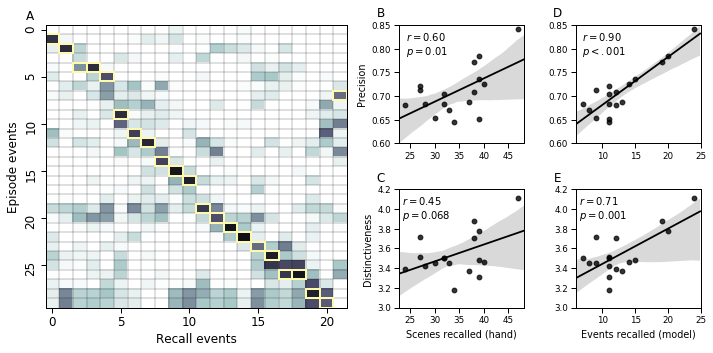

In [11]:
# general settings and parameters
fig = plt.figure()
fig.set_size_inches(10, 5)
gs = fig.add_gridspec(2, 4)

a = fig.add_subplot(gs[0:, :-2])
b = fig.add_subplot(gs[0, 2])
c = fig.add_subplot(gs[1, 2])
d = fig.add_subplot(gs[0, 3])
e = fig.add_subplot(gs[1, 3])

# format the data
precision = [precision_func(video_events, r) for r in recall_events]
distinctiveness = [distinctiveness_func(video_events, r) for r in recall_events]
n_recalled = np.array([np.unique(m).shape[0] for m in event_mappings])

df = pd.DataFrame(np.array([HAND_REC, n_recalled, precision, distinctiveness]).T, 
                  columns=['Scenes recalled (hand)', 
                           'Events recalled (model)', 
                           'Precision', 
                           'Distinctiveness'])

# precision schematic
p17_matchmat = 1 - cdist(video_events, recall_events[16], 'correlation')
sns.heatmap(p17_matchmat, 
            xticklabels=5, 
            yticklabels=5, 
            vmin=0, 
            vmax=1, 
            cmap=cmap, 
            cbar=False, 
            ax=a)
a.set_ylabel('Episode events', fontsize=12)
a.set_xlabel('Recall events', fontsize=12)
a.tick_params('both', labelsize=12)

for spine in a.spines.values():
    spine.set_visible(True)

a.hlines(range(video_events.shape[0]), *a.get_xlim(), linewidth=.25)
a.vlines(range(recall_events[16].shape[0]), *a.get_ylim(), linewidth=.25)

bounds = np.argmax(p17_matchmat, axis=0)
for i, bound in enumerate(bounds):
    rect = patches.Rectangle((i, bound), 
                             1, 1, 
                             linewidth=2, 
                             edgecolor=EDGECOLOR, 
                             facecolor='none', 
                             zorder=2, 
                             alpha=1)
    a.add_patch(rect)
    
# correlation plots
sns.regplot(x='Scenes recalled (hand)', 
            y='Precision', 
            data=df, 
            color='black', 
            ax=b)
sns.regplot(x='Scenes recalled (hand)', 
            y='Distinctiveness', 
            data=df, 
            color='black', 
            ax=c)
sns.regplot(x='Events recalled (model)', 
            y='Precision', 
            data=df, 
            color='black', 
            ax=d)
sns.regplot(x='Events recalled (model)', 
            y='Distinctiveness', 
            data=df, 
            color='black', 
            ax=e)

# add labels
a.text(-.05, 1.02, 
       'A', 
       horizontalalignment='center', 
       transform=a.transAxes, 
       fontsize=12)

labels = 'BCDE'
for ax, l in zip([b, c, d, e], labels):
    ax.text(-.15, 1.07, 
            l,
            horizontalalignment='center',
            transform=ax.transAxes,
            fontsize=12)

# format axes
b.set(ylim=(.6, .85), 
      xticks=np.arange(25, 50, 5), 
      yticks=np.arange(.6, .9, .05), 
      xlabel=None)

c.set(ylim=(3.0, 4.2), 
      xticks=np.arange(25, 50, 5), 
      yticks=np.arange(3.0, 4.4, .2))

d.set(xlim=(6, 25), 
      ylim=(.6, .85), 
      xticks=np.arange(5, 30, 5), 
      yticks=np.arange(.6, .9, .05), 
      xlabel=None, 
      ylabel=None)

e.set(xlim=(6, 25), 
      ylim=(3.0, 4.2), 
      xticks=np.arange(5, 30, 5), 
      yticks=np.arange(3.0, 4.4, .2),
      ylabel=None)
    
# add stats
cols = [('Precision', 'Scenes recalled (hand)'), 
        ('Distinctiveness', 'Scenes recalled (hand)'),
        ('Precision', 'Events recalled (model)'),
        ('Distinctiveness', 'Events recalled (model)')]

cis = dict.fromkeys(cols)
for ax, col in zip([b, c, d, e], cols):
    corr_func = corr_pearsonr if col[0] == 'Precision' else pearsonr
    stat = corr_func(df[col[0]], df[col[1]])
    cis[col] = pearsonr_ci(df[col[0]], df[col[1]], ci=95, n_boots=100000)
    ax.text(.22, .75, 
            fmt_stat(stat),
            horizontalalignment='center', 
            multialignment='left',
            transform=ax.transAxes,
            fontsize=10)

plt.subplots_adjust(wspace=.25, hspace=.25)
plt.tight_layout() 

# plt.savefig(FIG_DIR.joinpath('precision_distinctiveness.pdf'))
plt.show()

In [12]:
for cols, (ci_low, ci_high) in cis.items():
    print(cols)
    print(f"95% CI = ({round(ci_low, 2)}, {round(ci_high, 2)})\n")

('Precision', 'Scenes recalled (hand)')
95% CI = (0.02, 0.84)

('Distinctiveness', 'Scenes recalled (hand)')
95% CI = (-0.21, 0.78)

('Precision', 'Events recalled (model)')
95% CI = (0.55, 0.96)

('Distinctiveness', 'Events recalled (model)')
95% CI = (-0.06, 0.9)

